In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils_fig as uf
import power_utils as pu

from importlib import reload

import sys
sys.path.append("../include")
import hhtools
import hhsignal

sys.path.append("../extract_osc_motif/")
import oscdetector as od
import os

sys.path.append("../information_routing/")
import tetools as tt
import visu
import xarray as xa
import pickle as pkl


uf.set_plt()
reload(pu)


def load_pickle(fname):
    with open(fname, "rb") as fp:
        return pkl.load(fp)


def get_max_period(cid):
    fname = "../extract_osc_motif/data/osc_motif/amp_range_set.pkl"
    amp_range = load_pickle(fname)["amp_range_set"][cid]
    
    fs = [amp_range[k][0] for k in ("fpop", "spop")]
    max_period, nstack = 0, 0
    for f in fs:
        if len(f) > 0:
            max_period += np.average(f)
            nstack += 1
    if nstack == 0:
        max_period = 30
    else:
        max_period /= nstack
        
    return 1e3/max_period


kappa_dir = "../transmission_line/simulation_data/postdata/kappa_stat"
te_dir = "../information_routing/data/te_2d_newmotif_newsurr"
te_colors = ("#d92a27", "#045894", "#a9a9a9")
c_rect = "#676767"

Frites module is not activated


# Transmission line result - samples

In [5]:
kappa.kappa_base

<xarray.DataArray 'kappa_base' (nsample: 200, ndelay: 16, ntp: 2)>
[6400 values with dtype=float64]
Coordinates:
  * nsample  (nsample) int32 0 1 2 3 4 5 6 7 ... 192 193 194 195 196 197 198 199
  * ndelay   (ndelay) float64 0.0 2.0 4.0 6.0 8.0 ... 22.0 24.0 26.0 28.0 30.0
  * ntp      (ntp) int32 0 1

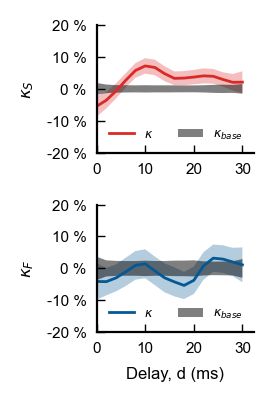

In [62]:
from scipy.ndimage import label


lb_set = ("S", "F")

def load_kappa(cid, wid):
    fname = os.path.join(kappa_dir, "kappa_%d%02d.nc"%(cid, wid))
    return xa.open_dataset(fname)


def get_err_range(data, method="quantile", qlen=0.05, smul=1.96):
    # Assume that data is 2D (nsamples, T)
    if method == "quantile":
        m = np.median(data, axis=0)
        smin = np.quantile(data, qlen, axis=0)
        smax = np.quantile(data, 1-qlen, axis=0)
    elif method == "std":
        m = data.mean(axis=0)
        s = data.std(axis=0) / np.sqrt(data.shape[0]) * smul
        smin = m - s
        smax = m + s
    else:
        raise ValueError("Unknown method: %s"%method)
    
    return m, smin, smax    


cid, wid = 4, 10
kappa_set = load_kappa(cid, wid)
tmax = get_max_period(cid)

# single figure
fig = plt.figure(figsize=(2.5*uf.cm, 6*uf.cm), dpi=200)
tsig_sets = []
axs = []
for npop in range(2):
    ax = plt.axes([0.12, 0.7-0.38*npop, 0.8, 0.27])
    axs.append(ax)
    
    t = kappa_set.ndelay.data
    ym_b, ymin_b, ymax_b = get_err_range(kappa_set.kappa_base.isel(dict(ntp=1-npop)).data, method="std")
    ym, ymin, ymax = get_err_range(kappa_set.kappa.isel(dict(ntp=1-npop)).data, method="std")
    
    plt.plot(t, ym, color=te_colors[npop], lw=1, label=r"$\kappa$")
    plt.fill_between(t, ymin, ymax, color=te_colors[npop], alpha=0.3, edgecolor="none")
    plt.fill_between(t, ymin_b, ymax_b, color="k", alpha=0.5, edgecolor="none", label=r"$\kappa_{base}$")
    plt.xlim([0, tmax])
    plt.legend(loc="lower right", fontsize=4.5, edgecolor="none", facecolor="none", ncol=2)
    
    plt.ylim([-0.2, 0.2])
    plt.xticks(np.arange(0, 31, 10))
    plt.yticks(np.arange(-0.2, 0.3, 0.1), labels=[str("%d %%"%(int(100*x))) for x in np.arange(-0.2, 0.3, 0.1)])
    
    if npop == 1:
        plt.xlabel("Delay, d (ms)")
    plt.ylabel(r"$\kappa_%s$"%(lb_set[npop]))
    

(-3.7191709844559586, 34.10259067357512, -1.2, 5.2)

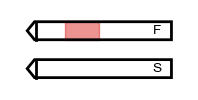

In [64]:
plt.figure(figsize=(2.6*uf.cm, 1.*uf.cm), dpi=200)
y0 = 4
box_height = 2

tsig_sets_e = [[[7, 15]], []]
tsig_sets_i = [[], []]

visu.draw_round_rect(tsig_sets_e[0], xmax=tmax, y=y0, color=te_colors[0], rect_type="sharp",
                     h=box_height, alpha=0.5, lw=0.5, show_arrow=True, arrow_h=0)
visu.draw_round_rect(tsig_sets_e[1], xmax=tmax, y=0, color=te_colors[0], rect_type="sharp", 
                     h=box_height, alpha=0.5, lw=0.5, show_arrow=True, arrow_h=0)

visu.draw_round_rect(tsig_sets_i[1], xmax=tmax, y=0, color=te_colors[1], rect_type="sharp", 
                     h=box_height, alpha=0.5, lw=0.5, show_arrow=True, arrow_h=0)

visu.draw_reduce_axis(xmax=tmax, width=box_height*1.2, y=y0)

plt.ylim([-1.2, y0+1.2])

plt.axis("off")

(-3.7191709844559586, 34.10259067357512, -1.2, 5.2)

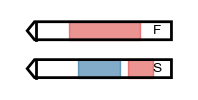

In [61]:
plt.figure(figsize=(2.6*uf.cm, 1.*uf.cm), dpi=200)
y0 = 4
box_height = 2

tsig_sets_e = [[[8, 25]], [[22, 28]]]
tsig_sets_i = [[[0, 8]], [[10, 20]]]

visu.draw_round_rect(tsig_sets_e[0], xmax=tmax, y=y0, color=te_colors[0], rect_type="sharp",
                     h=box_height, alpha=0.5, lw=0.5, show_arrow=True, arrow_h=0)
visu.draw_round_rect(tsig_sets_e[1], xmax=tmax, y=0, color=te_colors[0], rect_type="sharp", 
                     h=box_height, alpha=0.5, lw=0.5, show_arrow=True, arrow_h=0)

visu.draw_round_rect(tsig_sets_i[1], xmax=tmax, y=0, color=te_colors[1], rect_type="sharp", 
                     h=box_height, alpha=0.5, lw=0.5, show_arrow=True, arrow_h=0)

visu.draw_reduce_axis(xmax=tmax, width=box_height*1.2, y=y0)

plt.ylim([-1.2, y0+1.2])

plt.axis("off")

# Transmission line result - samples

(-3.7191709844559586, 34.10259067357512, -3.0, 7.0)

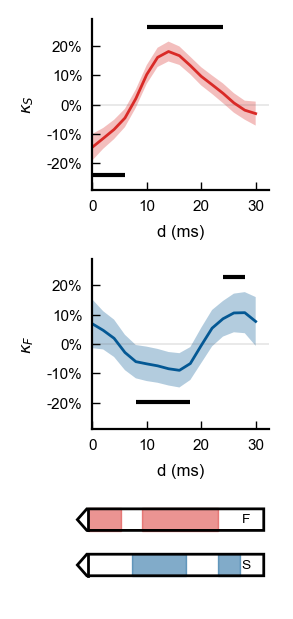

In [2]:
from scipy.ndimage import label


lb_set = ("S", "F")

def load_kappa(cid, wid):
    fname = os.path.join(kappa_dir, "kappa_%d%02d.nc"%(cid, wid))
    return xa.open_dataset(fname)

def rescale_ylim(axs):
    yl_set = [0, 0]
    for ax in axs:
        yl = ax.get_ylim()
        if yl[0] < yl_set[0]:
            yl_set[0] = yl[0]
        if yl[1] > yl_set[1]:
            yl_set[1] = yl[1]

    ym = max(-yl_set[0], yl_set[1])       
    yl_set = (-ym, ym)
    ym10 = np.floor(ym/10) * 10

    for ax in axs:
        ax.set_ylim(yl_set)
        
        yt = np.arange(-ym10, ym10+1, 10)
        ax.set_yticks(yt, [f"{p:.0f}%" for p in yt])


def get_sig_times(t, is_significant):
    lb, n = label(is_significant)
    tsig = []
    for i in range(1, n+1):
        idx = np.where(lb == i)[0]
        if len(idx) > 0:
            tsig.append((t[idx[0]], t[idx[-1]]))
    return tsig
    

cid, wid = 4, 15
kappa = load_kappa(cid, wid)
tmax = get_max_period(cid)

# single figure
fig = plt.figure(figsize=(2.8*uf.cm, 8*uf.cm), dpi=200)
tsig_sets = []
axs = []
for nd in range(2):
    ax = plt.axes([0.12, 0.7-0.38*nd, 0.8, 0.27])
    axs.append(ax)
    
    t = kappa.ndelay.data
    y = kappa.kappa.isel(dict(ntp=1-nd)).data
    
    ym = y.mean(axis=0) * 100
    yerr = y.std(axis=0) / np.sqrt(y.shape[0]) * 2.58 * 100
    
    tsig_sets.append(get_sig_times(t, kappa.is_significant.isel(dict(ntp=1-nd)).data))
    
    plt.hlines(0, 0, tmax, color=c_rect, lw=0.1)
    plt.plot(t, ym, color=te_colors[nd], lw=1)
    plt.fill_between(t, ym-yerr, ym+yerr, color=te_colors[nd], alpha=0.3, edgecolor="none")
    plt.xlim([0, tmax])
    plt.xticks(np.arange(0, tmax+1, 10))
    plt.xlabel("d (ms)")
    plt.ylabel(r"$\kappa_{%s}$"%(lb_set[nd]))
    
    ymax = (ym + yerr).max() + 5
    ymin = (ym - yerr).min() - 5
    for tsig in tsig_sets[nd]:
        n0 = np.where(t == tsig[0])[0][0]
        y0 = ymin if ym[n0] < 0 else ymax
        plt.hlines(y0, tsig[0], tsig[1], color="k", lw=1.5)
    
    

rescale_ylim(axs)

plt.axes([0.01, 0.05, 0.93, 0.18])
y0 = 4
box_height = 2


visu.draw_round_rect(tsig_sets[0], xmax=tmax, y=y0, color=te_colors[0], rect_type="sharp",
                     h=box_height, alpha=0.5, lw=0.5, show_arrow=True, arrow_h=0)
visu.draw_round_rect(tsig_sets[1], xmax=tmax, y=0, color=te_colors[1], rect_type="sharp", 
                     h=box_height, alpha=0.5, lw=0.5, show_arrow=True, arrow_h=0)
visu.draw_reduce_axis(xmax=tmax, width=box_height*1.2, y=y0)

plt.ylim([-3, y0+3])

plt.axis("off")

# Show the entire diagram with TE result

In [122]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import find_peaks


def load_te(cid, wid):
    tmax = get_max_period(cid)
    te_data_2d = uf.load_pickle(os.path.join(te_dir, "te_%d%02d.pkl"%(cid, wid)))
    te_data = tt.reduce_te_2d(te_data_2d, tcut=tmax)
    return te_data


def find_sig_times(tlag, x1_mean, is_overlap):
    idx_non_overlap = tt.bool2ind(~is_overlap)
    
    # find peaks
    loc_p, _ = find_peaks(x1_mean)
    loc_t, _ = find_peaks(-x1_mean)
    loc_p = loc_p.reshape(-1, 1)
    loc_t = loc_t.reshape(-1, 1)
    
    # find nearest peak / trough
    idx_sig_peak = []
    for idx in idx_non_overlap:
        arr = np.arange(idx[0], idx[1]+1).reshape(1, -1)
        dmin_p = np.min(np.abs(loc_p - arr), axis=0)
        dmin_t = np.min(np.abs(loc_t - arr), axis=0)
        
        # if np.any(dmin_p < dmin_t):
        # print(np.sum(dmin_p < dmin_t), len(dmin_p)*0.1)
        if np.sum(dmin_p < dmin_t) > len(dmin_p) * 0.1:
            idx_sig_peak.append(idx)
        
    # get significant times
    tsig_set = []
    for idx in idx_sig_peak:
        tsig_set.append(tlag[idx])
        
    return tsig_set


def find_sig_te(te_data):
    tsig_sets = [[], []]
    for nd in range(2):
        x1 = te_data["te"][:,nd,:]
        x2 = te_data["te_surr"][:,nd,:]
        x1_mean = np.median(x1, axis=0)
        is_overlap = tt.check_overlap(x1, x2, p_ranges)
        tsig_sets[nd] = find_sig_times(te_data["tlag"], x1_mean, is_overlap)
    return tsig_sets


p_ranges = (2.5, 97.5)

In [111]:
cw_pairs = [
    [(2, 2), (1, 2), (4, 2)],
    [(2, 10), (1, 5), (4, 5)],
    [(6, 10), [], (4, 10)],
    [(5, 4), [], (4, 15)],
    [(5, 10), [], (3, 2)],
    [(5, 14), [], (3, 15)],
    [(7, 2), (7, 5), (7, 15)]
]


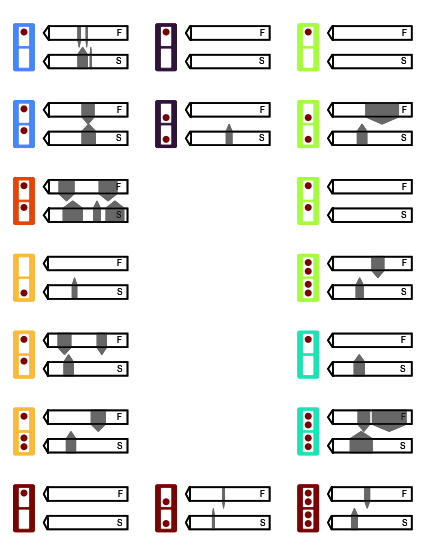

In [125]:
num_row = 7
num_col = 3

ws_row = 0.01
ws_col = 0.05

wr = (1-(num_row+1)*ws_row)/num_row
wc = (1-(num_col+1)*ws_col)/num_col

box_height = 2

fig = plt.figure(figsize=(9.5*uf.cm, 11.5*uf.cm), dpi=120)

for nr in range(num_row):
    for nc in range(len(cw_pairs[nr])):
        if len(cw_pairs[nr][nc]) == 0:
            continue
        
        cid, wid = cw_pairs[nr][nc]
        tmax = get_max_period(cid)

        # compute peaks
        te_data = load_te(cid, wid)
        tlag = te_data["tlag"]
        tsig_sets = find_sig_te(te_data)
            
        # show axis
        pos = ((nc+1)*ws_col+nc*wc, 1-((nr+1)*ws_row+nr*wr)-wr, wc, wr)
        ax = plt.axes(pos)
            
        ax_te = ax.inset_axes([0.23, 0., 0.77, 1])
        fig.add_axes(ax_te)
        plt.sca(ax_te)
        box_height = 2
        visu.draw_round_rect(tsig_sets[0], xmax=tmax, y=y0, color=c_rect, rect_type="sharp", h=box_height,
                     alpha=1, lw=0.5, show_arrow=True, arrow_h=-box_height/2)
        visu.draw_round_rect(tsig_sets[1], xmax=tmax, y=0, color=c_rect, rect_type="sharp", h=box_height,
                     alpha=1, lw=0.5, show_arrow=True, arrow_h=box_height/2)
        visu.draw_reduce_axis(xmax=tmax, width=box_height*1.2, y=y0)
        plt.ylim([-3, y0+3])

        # draw indicator
        ax_pict = ax.inset_axes([0, 0.1, 0.2, 0.8])
        fig.add_axes(ax_pict)
        plt.sca(ax_pict)
        uf.draw_motif_pictogram(od.get_motif_labels()[wid], rcolor=uf.get_cid_color(cid), )

        ax.axis("off")
        
# uf.save_fig("fig3_te_total")
plt.show()

In [124]:
reload(uf)

<module 'utils_fig' from '/home/jungyoung/Project/hh_neuralnet/figures/utils_fig.py'>

In [28]:
yl_set

(-0.09205175014221109, 0.09205175014221109)

In [5]:
kappa

<xarray.Dataset>
Dimensions:         (nsample: 100, ndelay: 16, ntp: 2)
Coordinates:
  * nsample         (nsample) int32 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99
  * ndelay          (ndelay) float64 0.0 2.0 4.0 6.0 8.0 ... 24.0 26.0 28.0 30.0
  * ntp             (ntp) int32 0 1
Data variables:
    kappa           (nsample, ndelay, ntp) float64 ...
    kappa_base      (nsample, ndelay, ntp) float64 ...
    is_significant  (ndelay, ntp) bool ...
    is_positive     (ndelay, ntp) int32 ...
Attributes:
    cid:                 1
    wid:                 2
    gaussian_smoothing:  1
    spk_dir:             ../transmission_line/simulation_data/postdata/
    ntp:                 0: F(R), 1: S(R)
    stat_test:           ttest_rel
    stat_alpha:          0.005
    threshold:           0.05
    threshold_applied:   0

In [21]:
# Parameter setting
te_dir = "../information_routing/data/te_2d_newmotif_newsurr"
te_colors = ("#d92a27", "#045894", "#a9a9a9")
c_rect = "#676767"


# configure period_cut
amp_range_tot = uf.load_pickle("../extract_osc_motif/data/osc_motif/amp_range_set.pkl")["amp_range_set"]


from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.stats import ttest_1samp, wilcoxon


def get_period(cid):
    # use amp_range_tot
    amp_range = amp_range_tot[cid-1]
    
    fmeans = [-1, -1]    
    for nf in range(2):
        if len(amp_range["fpop"][nf]) == 0 and len(amp_range["spop"][nf]) == 0:
            continue
        elif len(amp_range["fpop"][nf]) == 0:
            fmeans[nf] = np.mean(amp_range["spop"])
        elif len(amp_range["spop"][nf]) == 0:
            fmeans[nf] = np.mean(amp_range["fpop"])
        else:
            fmeans[nf] = np.mean(list(amp_range["spop"][nf]) + list(amp_range["fpop"][nf]))
    
    return [1e3/f for f in fmeans] # converted to ms


def get_period_max(cid):
    period = get_period(cid)
    if period[0] < 0:
        return 30
    else:
        return period[0]


def load_te(cid, wid):
    te_data_2d = uf.load_pickle(os.path.join(te_dir, "te_%d%02d.pkl"%(cid, wid)))
    return tt.reduce_te_2d(te_data_2d, tcut=get_period_max(cid))


def load_spk(cid, wid):
    fname = os.path.join("../transmission_line/simulation_data/postdata", "prob_spk_set_nc%d_sample.nc"%(cid-1))
    ds = xa.open_dataset(fname)
    if wid not in ds.nw:
        raise ValueError(f"wid {wid} does not exist in spike response")
        
    return ds.sel(nw=wid)
    
    
def find_sig_idx(x1_mean, is_overlap, keep_only_peak=True):
    
    idx_non_overlap = tt.bool2ind(~is_overlap)
    if not keep_only_peak:
        return idx_non_overlap
    
    # find peaks
    loc_p, _ = find_peaks(x1_mean)
    loc_t, _ = find_peaks(-x1_mean)
    loc_p = loc_p.reshape(-1, 1)
    loc_t = loc_t.reshape(-1, 1)
    
    # find nearest peak / trough
    idx_sig_peak = []
    for idx in idx_non_overlap:
        arr = np.arange(idx[0], idx[1]+1).reshape(1, -1)
        
        dmin_p = np.min(np.abs(loc_p - arr), axis=0)
        dmin_t = np.min(np.abs(loc_t - arr), axis=0)
        if np.sum(dmin_p < dmin_t) > len(dmin_p) * 0.1:
            idx_sig_peak.append(idx)
        
    return idx_sig_peak


def draw_te(te_pkl):
    tlag = te_pkl["tlag"]
    visu.draw_with_err(tlag, te_pkl["te"][:,0,:], c=te_colors[1])
    visu.draw_with_err(tlag, te_pkl["te"][:,1,:], c=te_colors[0])

    
p_ranges = (5, 95)
opt = dict(alpha=0.5, avg_method='median', p_range=p_ranges)
opt_line = dict(linestyle="-", linewidth=0.5)
opt_noline = dict(linestyle="none")

# Use different method to normalzie spike response

In [198]:
cid, wid = 7, 15


te_pkl = load_te(cid, wid)
te_pkl_base = load_te(cid, 0)
spk_xa = load_spk(cid, wid)
spk_xa_base = load_spk(cid, 0)
pmax = get_period_max(cid)

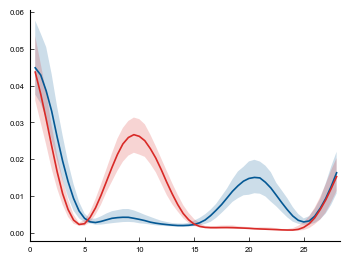

In [199]:
plt.figure(figsize=(4, 3))
draw_te(te_pkl)
plt.xlim([0, pmax])
plt.show()

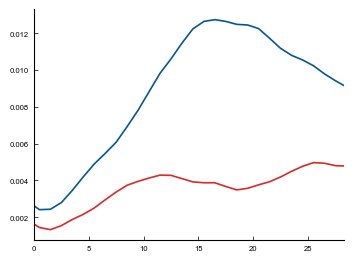

In [153]:
plt.figure(figsize=(4, 3))
for ntp in range(2):
    
    spk_sub = spk_xa.isel(dict(ntp=ntp))
    spk_sub_base = spk_xa_base.isel(dict(ntp=ntp))
    
    # dy = spk_sub.prob - spk_sub.prob0 - spk_sub_base.prob + spk_sub_base.prob0
    dy = spk_sub.prob - spk_sub.prob0
    dy_mean = dy.median("nsample")
    dy_mean = dy_mean.mean("ndelay")
    
    dy_mean = gaussian_filter1d(dy_mean, 1)
    
    plt.plot(spk_sub.t, dy_mean, c=te_colors[ntp])
plt.xlim([0, pmax])
plt.show()

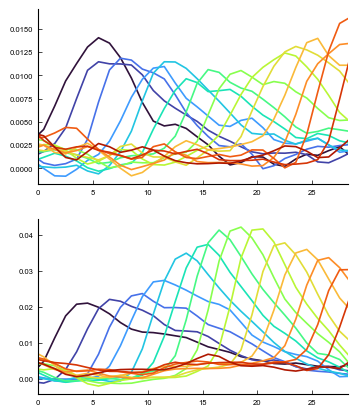

In [116]:
from scipy.ndimage import gaussian_filter1d

cmap = plt.get_cmap("turbo")

plt.figure(figsize=(4, 5))
for ntp in range(2):
    plt.subplot(2,1,ntp+1)
    for nd in range(15):
        spk_sub = spk_xa.isel(dict(ndelay=nd, ntp=ntp))
        spk_sub_base = spk_xa_base.isel(dict(ndelay=nd, ntp=ntp))
        dy = spk_sub.prob - spk_sub.prob0
        # dy = spk_sub.prob - spk_sub.prob0 - spk_sub_base.prob + spk_sub_base.prob0
        # dy = spk_sub.prob - spk_sub.prob0
        dy = dy.mean("nsample")
        dy = gaussian_filter1d(dy, 1)
        plt.plot(spk_xa.t, dy, c=cmap(nd/15))
    plt.xlim([0, pmax])
    # plt.plot(spk_xa.t, spk_xa.prob.isel(dict(ndelay=nd, ntp=0)).mean("nsample"))
# plt.plot(spk_xa.t, spk_xa.prob.isel(dict(ndelay=0, ntp=0)).mean("nsample"))
plt.show()

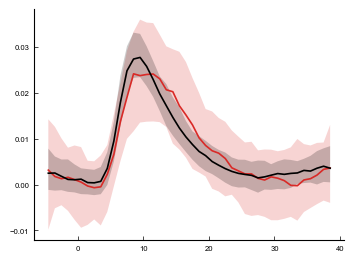

In [212]:
ntp = 1
nd  = 2

plt.figure(figsize=(4, 3))
# spk_sub = spk_xa.isel(dict(ndelay=nd, ntp=ntp)).median("nsample")
# spk_sub_base = spk_xa_base.isel(dict(ndelay=nd, ntp=ntp)).median("nsample")
spk_sub = spk_xa.isel(dict(ndelay=nd, ntp=ntp))
spk_sub_base = spk_xa_base.isel(dict(ndelay=nd, ntp=ntp))

def _plot(y):
    plt.plot(spk_sub.t, gaussian_filter1d(y, 1))
    
def _plot_sample(y, c="k"):
    visu.draw_with_err(spk_sub.t, gaussian_filter1d(y, 1, axis=-1), c=c)

# _plot(spk_sub.prob - spk_sub.prob0)
# _plot(spk_sub_base.prob - spk_sub_base.prob0)
# _plot(spk_sub.prob)
# _plot(spk_sub_base.prob)

_plot_sample(spk_sub.prob - spk_sub.prob0, c=te_colors[0])
_plot_sample(spk_sub_base.prob - spk_sub_base.prob0, c="k")

plt.show()

In [ ]:
# Try differen method to 



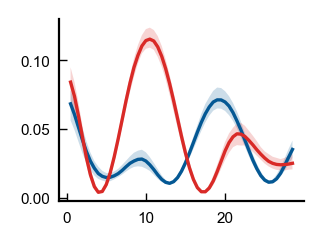

In [27]:
plt.figure(figsize=(4*uf.cm, 3*uf.cm), dpi=200)

draw_te(te_pkl)

In [ ]:
plt.plot(spk_xa

In [13]:
spk_xa

<xarray.Dataset>
Dimensions:  (nsample: 100, t: 44, ndelay: 16, ntp: 2)
Coordinates:
  * nsample  (nsample) int32 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * t        (t) float64 -4.5 -3.5 -2.5 -1.5 -0.5 ... 34.5 35.5 36.5 37.5 38.5
  * ndelay   (ndelay) float64 0.0 2.0 4.0 6.0 8.0 ... 22.0 24.0 26.0 28.0 30.0
    nw       int32 15
  * ntp      (ntp) int32 0 1
Data variables:
    prob     (ndelay, nsample, ntp, t) float64 ...
    prob0    (ndelay, nsample, ntp, t) float64 ...
Attributes:
    ntp:         0: F(R), 1: S(R)
    fdir:        ./simulation_data/data
    nc:          2
    cluster_id:  3.0
    num_trans:   40

In [8]:
1 in ds.nw

False

In [7]:
ds.nw

<xarray.DataArray 'nw' (nw: 3)>
array([ 0,  2, 15], dtype=int32)
Coordinates:
  * nw       (nw) int32 0 2 15

In [ ]:
cid, wid = 3, 15



# Visualize TE and spike response together

In [944]:
def compute_resp_samples(ds, nw, ntp, s=1):
    p_resp_samples = np.zeros((len(ds.nsample), len(ds.ndelay)))
    p_resp_mean = np.zeros(len(ds.ndelay))
    # compute \Delta p
    for i, nd in enumerate(ds.ndelay):
        cond = dict(ndelay=nd, nw=nw, ntp=ntp)
        # find increased activity
        y1 = ds.prob.sel(cond).mean("nsample")
        y0 = ds.prob0.sel(cond).mean("nsample")
        y1 = gaussian_filter1d(y1, s) # 
        y0 = gaussian_filter1d(y0, s)
        dy = y1 - y0
        # find max point
        idy_max = np.argmax(dy)

        # repeat this process without average
        ys1 = ds.prob.sel(cond)
        ys0 = ds.prob0.sel(cond)
        dys = (ys1 - ys0).data
        dys = gaussian_filter1d(dys, s, axis=1) # t

        # collect sample
        p_resp_samples[:, i] = dys[:, idy_max]
        p_resp_mean[i] = dy[idy_max]
    
    p_resp_samples = gaussian_filter1d(p_resp_samples, s, axis=1) # delay
    p_resp_mean = gaussian_filter1d(p_resp_mean, s)
        
    return p_resp_samples, p_resp_mean

In [211]:
wid = 10
ntp = 1

fname = os.path.join("../transmission_line/simulation_data/postdata", "prob_spk_set_nc%d.nc"%(cid-1))
ds = xr.open_dataset(fname)

p_resp = np.zeros(len(ds.ndelay))
p_resp_base = np.zeros(len(ds.ndelay))

for i, nd in enumerate(ds.ndelay):
    dset = ds.sel(dict(ndelay=nd, nw=wid, ntp=ntp))
    dy = gaussian_filter1d(dset.prob.data - dset.prob0.data, 1)
    p_resp[i] = dy.max()
    
    dset = ds.sel(dict(ndelay=nd, nw=0, ntp=ntp))
    dy = gaussian_filter1d(dset.prob.data - dset.prob0.data, 1)
    p_resp_base[i] = dy.max()
    
p_resp = gaussian_filter1d(p_resp, 1)
p_resp_base = gaussian_filter1d(p_resp_base, 1)

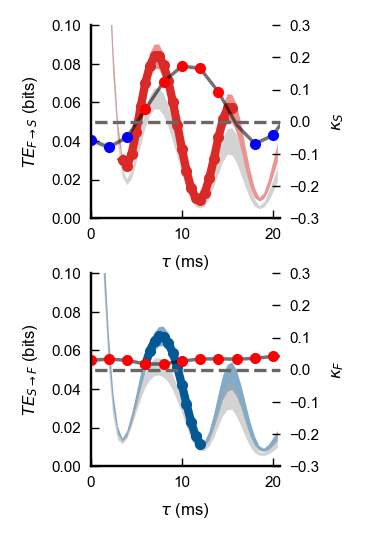

In [1028]:
cid = 5
wid = 10
s = 1

period_set = get_period(cid)
if period_set[0] < 0: period_set[0] = 30

lb_pop = ("F", "S")
# p_ranges = (2.5, 97.5)
p_ranges = (5, 95)

# load TE
te_data_2d = load_te(cid, wid)
te_data = tt.reduce_te_2d(te_data_2d, tcut=period_set[0])
# te_data = tt.reduce_te_2d(te_data_2d, tcut=None)

# load spk-resp
ds = load_spk(cid)
plt.figure(figsize=(3*uf.cm, 7.*uf.cm), dpi=200)

for ntp in range(2):
    # plt.subplot(2,1,ntp+1)
    plt.axes(position=(0.1, 0.55-0.45*ntp, 0.8, 0.35))

    # draw TE
    tlag = te_data["tlag"]
    x = te_data["te"][:,ntp,:]
    xp = te_data["te_surr"][:,ntp,:]

    visu.draw_with_err(tlag, x, c=te_colors[ntp], **opt, **opt_noline) # TE
    visu.draw_with_err(tlag, xp, c=te_colors[2], **opt, **opt_noline) # TE surrogate
    x_mean = np.median(x, axis=0)
    is_overlap = tt.check_overlap(x, xp, p_ranges)
    tsig_set = find_sig_times(x_mean, is_overlap)
    for tr in tsig_set:
        n0 = np.where(tlag == tr[0])[0][0]
        n1 = np.where(tlag == tr[1])[0][0]
        plt.plot(tlag[n0:n1], x_mean[n0:n1], '.-', c=te_colors[ntp], lw=3)
    plt.ylim([0, 0.1])
    plt.xlabel(r"$\tau$ (ms)")
    plt.ylabel(r"$TE_{%s \rightarrow %s}$ (bits)"%(lb_pop[ntp], lb_pop[1-ntp]))

    # draw spk-resp
    plt.twinx()
    ndelay = ds.ndelay
    
    p_resp_samples, _ = compute_resp_samples(ds, wid, 1-ntp, s=s)
    p_resp_base, m = compute_resp_samples(ds, 0, 1-ntp, s=s)
    z = (p_resp_samples - m)/m

    # stat test
    p_set = []
    sign_set = []
    for n in range(16):
        t_stat, p = ttest_1samp(z[:,n], popmean=0)
        p_set.append(p)
        sign_set.append(t_stat > 0)
    p_set = np.array(p_set)
    sign_set = np.array(sign_set)

    zm = z.mean(axis=0)
    zs = z.std(axis=0)/np.sqrt(z.shape[0])
    plt.plot(ndelay, zm, '-', c="k", alpha=0.5)
    plt.fill_between(ndelay, zm-zs, zm+zs, facecolor='k', alpha=0.1, edgecolor='none') 

    alpha = 0.01
    plt.plot(ndelay[(p_set<alpha) & sign_set], zm[(p_set<alpha) & sign_set], 'r.')
    plt.plot(ndelay[(p_set<alpha) & ~sign_set], zm[(p_set<alpha) & ~sign_set], 'b.')

    xl = plt.xlim()
    plt.plot(xl, [0, 0], "--", color=c_rect)
    plt.xlim([0, period_set[0]])
    plt.ylim([-0.3, 0.3])
    plt.ylabel(r"$\kappa_%s$"%(lb_pop[1-ntp]))

# uf.save_fig("fig4_te_tline/fig_%d%02d"%(cid, wid))
plt.show()

Compare with TE

In [459]:
cid, wid = 4, 10

te_data_2d = load_te(cid, wid) # TE
te_data = tt.reduce_te_2d(te_data_2d, tcut=period_set[0])
te_data_base = tt.reduce_te_2d(load_te(cid, 0), tcut=period_set[0])
tlag = te_data["tlag"]

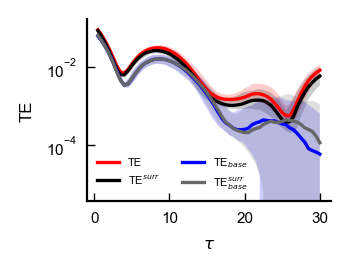

In [578]:
ndir = 1

y1 = te_data["te"][:,ndir,:]
y2 = te_data_base["te"][:,ndir,:]
y1_surr = te_data["te_surr"][:,ndir,:]
y2_surr = te_data_base["te_surr"][:,ndir,:]

plt.figure(figsize=(4*uf.cm, 3*uf.cm), dpi=200)

visu.draw_with_err(tlag, y1, c='r', label="TE")
visu.draw_with_err(tlag, y1_surr, c='k', label=r"TE$^{surr}$")
visu.draw_with_err(tlag, y2, c="b", label=r"TE$_{base}$")
visu.draw_with_err(tlag, y2_surr, c=c_rect, label=r"TE$^{surr}_{base}$")

plt.gca().set_yscale("log")
plt.xlabel(r"$\tau$")
plt.ylabel("TE")
plt.legend(fontsize=4, edgecolor="none", facecolor="none", ncol=2)

plt.show()

# Draw summerized result

In [1010]:
def get_period_max(cid):
    pmax = get_period(cid)[0]
    if pmax < 0: pmax = 30
    return pmax
    

def identify_te_sig_sets(cid, wid, p_ranges=(2.5, 97.5)):
    
    pmax = get_period_max(cid)
    
    te_data_2d = load_te(cid, wid) # TE
    te_data = tt.reduce_te_2d(te_data_2d, tcut=pmax)
    
    te_sig_sets = []
    for ntp in range(2):
        x1, x2 = te_data["te"][:,ntp,:], te_data["te_surr"][:,ntp,:]
        is_overlap_surr = tt.check_overlap(x1, x2, p_ranges)

        idx = find_sig_idx(np.median(x1, axis=0), is_overlap_surr)
        te_sig_sets.append(te_data["tlag"][idx])
    
    return te_sig_sets


def identify_tline_sig_sets(cid, wid, alpha=0.01):
    
    ds = load_spk(cid) # spike response
    tline_sig_sets = [
        [[], []], # F(R)-positive/negative
        [[], []]  # S(R)-positive/negative
    ]
    
    for ntp in range(2):
        # spike resp
        p_resp_samples, _ = compute_resp_samples(ds, wid, ntp, s=s)
        p_resp_base, m = compute_resp_samples(ds, 0, ntp, s=s)
        z = (p_resp_samples - m)/m

        spk_sig, spk_is_pos = [], []
        for n in range(len(ds.ndelay)):
            t_stat, p = ttest_1samp(z[:,n], popmean=0)
            if p < alpha:
                if len(spk_sig) == 0:
                    spk_sig.append([n, n])
                    spk_is_pos.append(t_stat > 0)
                else:
                    if n-spk_sig[-1][1] == 1 and not (spk_is_pos[-1]^(t_stat > 0)):
                        spk_sig[-1][1] = n
                    else:
                        spk_sig.append([n, n])
                        spk_is_pos.append(t_stat > 0)
                        
        # cut signal
        pmax = get_period_max(cid)
        for i in range(len(spk_is_pos)):
            nsign = 1-int(spk_is_pos[i])
            tr = ds.ndelay.data[spk_sig[i]]
            if tr[0] > pmax:
                continue
            elif tr[1] > pmax:
                tr[1] = pmax
            tline_sig_sets[ntp][nsign].append(tr)
        
    return tline_sig_sets

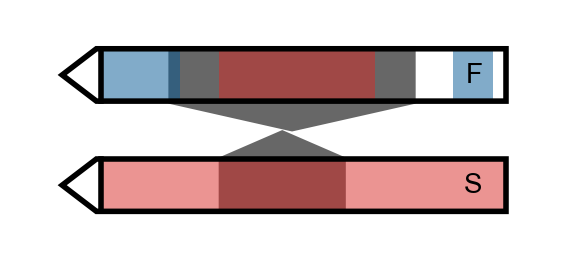

In [1015]:
cid = 5
wid = 10

# parameter setting
s = 1
# p_ranges = (2.5, 97.5)
p_ranges = (5, 95)
lb_pop = ("F", "S")
alpha = 0.01
te_colors = ("#d92a27", "#045894", "#a9a9a9")
c_rect = "#676767"

# compute sig timings
te_sig_sets = identify_te_sig_sets(cid, wid, p_ranges=p_ranges)
tline_sig_sets = identify_tline_sig_sets(cid, wid)

# Draw result
y0 = 4
xmax = get_period_max(cid)
box_height = 2

plt.figure(figsize=(4*uf.cm, 1.5*uf.cm), dpi=400)
visu.draw_round_rect(te_sig_sets[0], xmax=xmax, y=y0, color=c_rect, rect_type="sharp", h=box_height,
                     alpha=1, lw=0.5, show_arrow=True, arrow_h=-box_height/2)
visu.draw_round_rect(te_sig_sets[1], xmax=xmax, y=0, color=c_rect, rect_type="sharp", h=box_height, 
                     alpha=1, lw=0, show_arrow=True, arrow_h=box_height/2)

for ntp in range(2): # F(R), S(R)
    for nsign in range(2): # pos, neg
        visu.draw_round_rect(tline_sig_sets[ntp][nsign], xmax=30, y=y0*ntp, color=te_colors[nsign],
                             rect_type="sharp", lw=0, h=box_height, alpha=0.5)
        
visu.draw_reduce_axis(xmax=xmax, width=box_height*1.2, y=y0)

# plt.xlim([0, 30])


In [989]:
def draw_motif_pictogram(lb, rcolor="k"):
    from matplotlib.patches import Circle, FancyBboxPatch
    
    c_pict = "#7d0000"
    mid = read_motif(lb)
    
    r = 0.8
    x0 = 2
    y0 = 9
    dy1 = 2
    dy2 = 3.
    
    ax = plt.gca()
    # add rectangle
    # wbig = 1.5
    wbig = 2
    wb = 0.5
    w = 2
    robj_big = FancyBboxPatch((x0-wbig, y0-3*dy1-dy2+wb), 2*wbig, 4*dy1+dy2-2*wb, facecolor=rcolor, edgecolor="none", boxstyle="round, pad=0.5")
    robj_top = FancyBboxPatch((x0-w/2, y0-dy1/2*3), w, 2*dy1, edgecolor=rcolor, facecolor="w", lw=0.5, boxstyle="round, pad=0.3")
    robj_bot = FancyBboxPatch((x0-w/2, y0-dy2-dy1/2*5), w, 2*dy1, edgecolor=rcolor, facecolor="w", lw=0.5, boxstyle="round, pad=0.3")
    ax.add_patch(robj_big)
    ax.add_patch(robj_top)
    ax.add_patch(robj_bot)
    
    # add indicator
    
    
    y = y0
    for n in range(4):
        if mid[n] == 1:
            cobj = Circle((x0, y), radius=r, facecolor=c_pict)
            ax.add_patch(cobj)
        
        if n == 1:
            y -= dy2
        else:
            y -= dy1
            
    # add rectangle

    
    # plt.xlim([0, 4])
    # plt.ylim([0, 11])
    plt.xlim([-.5, 4.5])
    plt.ylim([-2, 12])
    plt.axis("off")
    plt.axis("equal")
    
    
def get_cid_color(cid, cmap="turbo"):
    cid_max = 7
    assert 0 < cid <= cid_max
    palette = plt.get_cmap(cmap)
    return palette((cid-1)/(cid_max-1))


def read_motif(lb):
    assert lb[0] == "F"

    mid = np.zeros(4)
    mid[0] = lb[2] == "f"
    mid[1] = lb[3] == "s"
    mid[2] = lb[7] == "f"
    mid[3] = lb[8] == "s"
    
    return mid

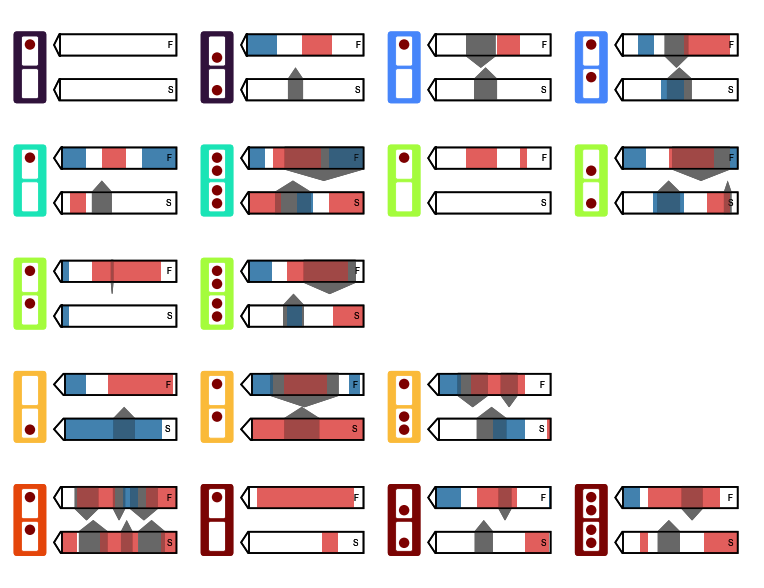

In [1013]:
cw_pairs = [
    [(1, 2), (1, 5), (2, 2), (2, 10)],
    [(3, 2), (3, 15), (4, 2), (4, 5)], 
    [(4, 10), (4, 15)], 
    [(5, 4), (5, 10), (5, 14)],
    [(6, 10), (7, 2), (7, 5), (7, 15)]
]

# ---- parameter setting
c_circ = "#7d0000"
c_rect = "#676767"
alpha = 0.01

num_row = len(cw_pairs)
num_col = 4
ws_row = 0.002
ws_col = 0.01

y0 = 4
box_height = 2

wr = (1-(num_row+1)*ws_row)/num_row
wc = (1-(num_col+1)*ws_col)/num_col

# draw figure
fig = plt.figure(figsize=(16*uf.cm, 12*uf.cm), dpi=120)
for nr in range(num_row):
    for nc in range(len(cw_pairs[nr])):
        if len(cw_pairs[nr][nc]) == 0:
            continue
        cid, wid = cw_pairs[nr][nc]
        pos = ((nc+1)*ws_col+nc*wc, 1-((nr+1)*ws_row+nr*wr)-wr, wc, wr)
        ax = plt.axes(pos)
        
        ax_te = ax.inset_axes([0.2, 0., 0.75, 1])
        fig.add_axes(ax_te)
        plt.sca(ax_te)
        
        te_sig_sets = identify_te_sig_sets(cid, wid, p_ranges=p_ranges)
        tline_sig_sets = identify_tline_sig_sets(cid, wid, alpha=alpha)
        
        xmax = get_period_max(cid)
        visu.draw_round_rect(te_sig_sets[0], xmax=xmax, y=y0, color=c_rect, rect_type="sharp", h=box_height,
                     alpha=1, lw=0.5, show_arrow=True, arrow_h=-box_height/2)
        visu.draw_round_rect(te_sig_sets[1], xmax=xmax, y=0, color=c_rect, rect_type="sharp", h=box_height, 
                             alpha=1, lw=0, show_arrow=True, arrow_h=box_height/2)
        for ntp in range(2): # F(R), S(R)
            for nsign in range(2): # pos, neg
                visu.draw_round_rect(tline_sig_sets[ntp][nsign], xmax=30, y=y0*ntp, color=te_colors[nsign],
                                     rect_type="sharp", lw=0, h=box_height, alpha=0.5)
        visu.draw_reduce_axis(xmax=xmax, width=box_height*1.2, y=y0)
        plt.ylim([-3, 7])
        
        ax_pict = ax.inset_axes([0, 0.1, 0.2, 0.8])
        fig.add_axes(ax_pict)
        plt.sca(ax_pict)
        draw_motif_pictogram(od.get_motif_labels()[wid], rcolor=get_cid_color(cid))
        
        ax.axis("off")
        
